<IPython.core.display.Javascript object>


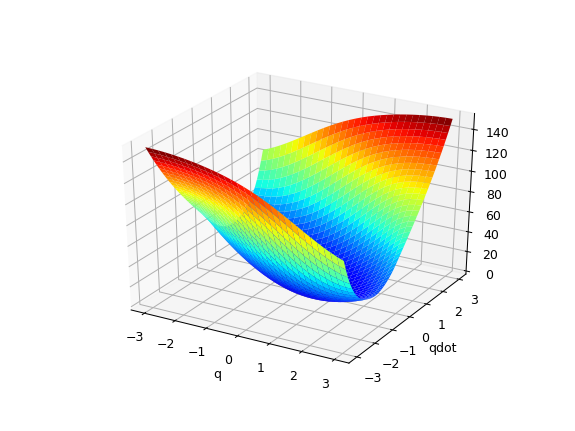

<IPython.core.display.Javascript object>


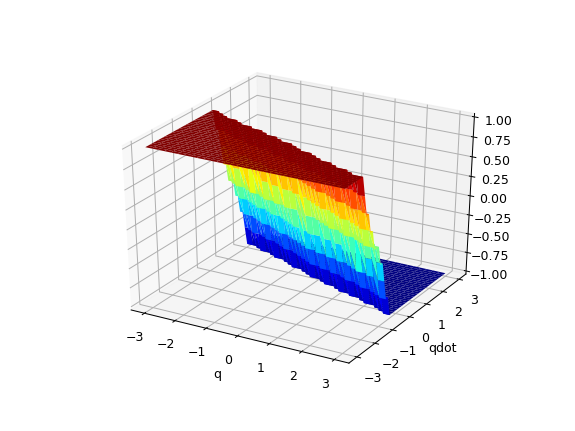

(51, 31)


In [2]:
%matplotlib notebook
from IPython import display
from __future__ import print_function, absolute_import

import math
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

from pydrake.systems.framework import VectorSystem
from pydrake.systems.primitives import LinearSystem, LinearSystem_
from pydrake.systems.analysis import Simulator
from pydrake.systems.controllers import (
    DynamicProgrammingOptions, FittedValueIteration)


A = np.array([[0, 1], [0, 0]])
B = np.array([[0], [1]])
C = np.identity(2)
D = np.array([[0], [0]])
# double_integrator = LinearSystem(A, B, C, D)

plant = LinearSystem(A, B, C, D)
# plant = DoubleIntegrator()
simulator = Simulator(plant)
options = DynamicProgrammingOptions()


def min_time_cost(context):
    x = context.get_continuous_state_vector().CopyToVector()
    if x.dot(x) < .05:
        return 0.
    return 1.


def quadratic_regulator_cost(context):
    x = context.get_continuous_state_vector().CopyToVector()
    u = plant.EvalVectorInput(context, 0).CopyToVector()
    return 2*x.dot(x) + 10*u.dot(u)


# cost_function = min_time_cost
cost_function = quadratic_regulator_cost

qbins = np.linspace(-3., 3., 31)
qdotbins = np.linspace(-3., 3., 51)
state_grid = [set(qbins), set(qdotbins)]

input_limit = 1.
input_grid = [set(np.linspace(-input_limit, input_limit, 9))]
timestep = 0.01

[Q, Qdot] = np.meshgrid(qbins, qdotbins)

fig = plt.figure()
ax = fig.gca(projection='3d')
ax.set_xlabel("q")
ax.set_ylabel("qdot")

fig2 = plt.figure()
ax2 = fig2.gca(projection='3d')
ax2.set_xlabel("q")
ax2.set_ylabel("qdot")


def draw(iteration, mesh, cost_to_go, policy):
    # Drawing is slow, don't draw every frame.
    if iteration % 10 != 0:
        return
    plt.title("iteration " + str(iteration))
    J = np.reshape(cost_to_go, Q.shape)
    surf = ax.plot_surface(Q, Qdot, J, rstride=1, cstride=1,
                           cmap=cm.jet)

    Pi = np.reshape(policy, Q.shape)
    surf2 = ax2.plot_surface(Q, Qdot, Pi, rstride=1, cstride=1, cmap=cm.jet)

#     if plt.get_backend() != u'template':
#         plt.draw_all()
#         plt.pause(0.00001)
        
    display.display(plt.gcf())
    display.clear_output(wait=True)

#     surf.remove()
#     surf2.remove()


# options.visualization_callback = draw

policy, cost_to_go = FittedValueIteration(simulator, cost_function,
                                          state_grid, input_grid,
                                          timestep, options)
print(Q.shape)
J = np.reshape(cost_to_go, Q.shape)
surf = ax.plot_surface(Q, Qdot, J, rstride=1, cstride=1,
                       cmap=cm.jet)
Pi = np.reshape(policy.get_output_values(), Q.shape)
surf = ax2.plot_surface(Q, Qdot, Pi, rstride=1, cstride=1,
                        cmap=cm.jet)

# plt.show()
# TODO: animate the resulting policy.

In [20]:
J = np.reshape(cost_to_go, Q.shape)
surf = ax.plot_surface(Q, Qdot, J, rstride=1, cstride=1,
                       cmap=cm.jet)
Pi = np.reshape(policy.get_output_values(), Q.shape)
surf = ax2.plot_surface(Q, Qdot, Pi, rstride=1, cstride=1,
                        cmap=cm.jet)
plt.show()

## Let's verify the cost to go against cost of many random (w/ random inits) dircols!

<IPython.core.display.Javascript object>


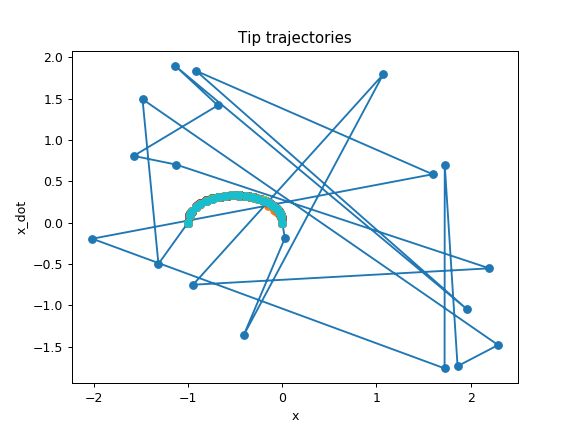

(<pydrake.systems.trajectory_optimization.DirectCollocation at 0x7f2775f23870>,
 SolutionResult.kSolutionFound)

In [2]:
from pydrake.all import (
    DirectCollocation, 
    PiecewisePolynomial, 
    SolutionResult,
)

vis_cb_counter = 0
dircol = None
plant = None
context = None
def do_dircol(ic=(-1., 0.), warm_start="linear", seed=1776, should_vis=False):
    global dircol
    global plant
    global context
    plant = LinearSystem(A, B, C, D)
    context = plant.CreateDefaultContext()
    dircol = DirectCollocation(plant, context, num_time_samples=21,
                               minimum_timestep=0.1, maximum_timestep=0.4)

    # dircol.AddEqualTimeIntervalsConstraints()

    torque_limit = input_limit  # N*m.
    u = dircol.input()
    dircol.AddConstraintToAllKnotPoints(-torque_limit <= u[0])
    dircol.AddConstraintToAllKnotPoints(u[0] <= torque_limit)

    initial_state = ic
    dircol.AddBoundingBoxConstraint(initial_state, initial_state,
                                    dircol.initial_state())
    final_state = (0., 0.)
    dircol.AddBoundingBoxConstraint(final_state, final_state,
                                    dircol.final_state())

#     R = 100  # Cost on input "effort".
    u = dircol.input()
    x = dircol.input()
    dircol.AddRunningCost(2*x.dot(x) + 10*u.dot(u))

    # Add a final cost equal to the total duration.
    dircol.AddFinalCost(dircol.time())

    if warm_start == "linear":
        initial_u_trajectory = PiecewisePolynomial()
        initial_x_trajectory = \
            PiecewisePolynomial.FirstOrderHold([0., 4.],
                                           np.column_stack((initial_state,
                                                            final_state)))
        dircol.SetInitialTrajectory(initial_u_trajectory, initial_x_trajectory)

    elif warm_start == "random":
        assert isinstance(seed, int)
        np.random.seed(seed)
        breaks = np.linspace(0, 4, 21).reshape((-1, 1))  # using num_time_samples
        u_knots = np.random.rand(1, 21)*2*input_limit-input_limit # num_inputs vs num_samples? 
        x_knots = np.random.rand(2, 21)*2*3-3 # num_states vs num_samples? 
        initial_u_trajectory = PiecewisePolynomial.Cubic(breaks, u_knots, False)
        initial_x_trajectory = PiecewisePolynomial.Cubic(breaks, x_knots, False)
        dircol.SetInitialTrajectory(initial_u_trajectory, initial_x_trajectory)

    
    def MyVisualization(sample_times, values):
        global vis_cb_counter

        vis_cb_counter += 1
        if vis_cb_counter % 5 != 0:
            return

        x, x_dot = values[0], values[1]
        plt.plot(x, x_dot, '-o', label=vis_cb_counter)
    
    if should_vis:
        plt.figure()
        plt.title('Tip trajectories')
        plt.xlabel('x')
        plt.ylabel('x_dot')
        dircol.AddStateTrajectoryCallback(MyVisualization)

    from pydrake.all import (SolverType)
    dircol.SetSolverOption(SolverType.kSnopt, 'Major feasibility tolerance', 2.0e-4) # default="1.0e-6"
    dircol.SetSolverOption(SolverType.kSnopt, 'Major optimality tolerance',  2.0e-4) # default="1.0e-6"
    dircol.SetSolverOption(SolverType.kSnopt, 'Minor feasibility tolerance', 2.0e-4) # default="1.0e-6"
    dircol.SetSolverOption(SolverType.kSnopt, 'Minor optimality tolerance',  2.0e-4) # default="1.0e-6"
    result = dircol.Solve()
#     print(result)
#     assert(result == SolutionResult.kSolutionFound)
#     print("used solver: ", dircol.GetSolverId().name())
    if result != SolutionResult.kSolutionFound:
        print("result={}".format(result))

    return dircol, result

do_dircol(warm_start="random", should_vis=True)

0 50 MSE: 1079.81097444


<IPython.core.display.Javascript object>


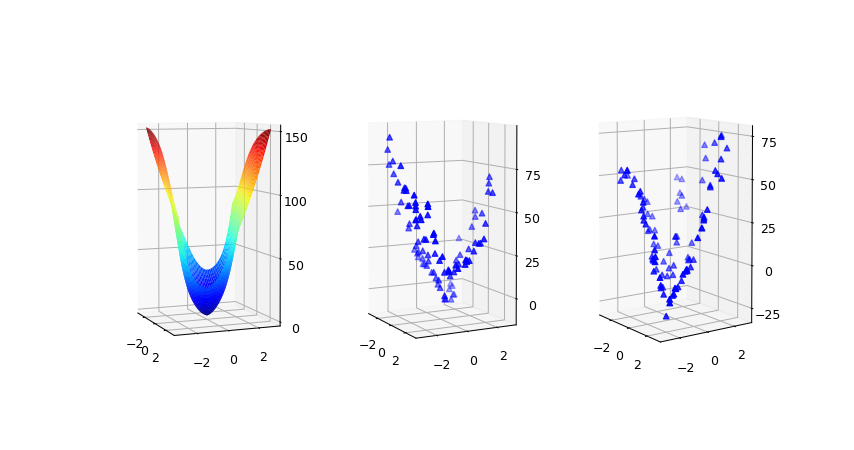

In [49]:
%matplotlib notebook
# Gen a bunch of random initial conditions
n = 100
xs = np.random.uniform(-3, 3, n)
x_dots = np.random.uniform(-3, 3, n)
ics = zip(xs, x_dots)

# Do dircol from them
J = np.reshape(cost_to_go, Q.shape)
found_values, expected_values = [], []
SSE = 0
for i, ic in enumerate(ics):
    # TODO: turn on the random initializations!!
    if i % 50 == 0:
        print("{} ".format(i), end='')
    dircol, result  = do_dircol(ic=ic, warm_start=None, seed=1776, should_vis=False)
    sum_cost        = np.sum([dircol.EvalBindingAtSolution(cost) for cost in dircol.GetAllCosts()])
    sum_constraints = np.sum([np.sum(dircol.EvalBindingAtSolution(constraint)) for constraint in dircol.GetAllConstraints()])
    found_value     = sum_cost + sum_constraints
    found_values.append(found_value)
    
    # TODO: Expected value might need to rely on barycentric interpolation? consider using BarycentricMeshSystem
    # Do it via the distance between the lower bound and the upper bound, rounded to to the nearest bin?
    nearest_xdot  = int(J.shape[0] * (ic[1] - -3)/(2*3))
    nearest_x     = int(J.shape[1] * (ic[0] - -3)/(2*3))
    expected_value  = J[nearest_xdot][nearest_x]
    expected_values.append(expected_value)
    SSE += (expected_value - found_value)**2
MSE = SSE / n
print("MSE: {}".format(MSE))
    
# Plot expected vs actual, in a 3d graph, since we have a 2d state space...
# Here's the reference graph, in all of it's glory...
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
ax = fig.add_subplot(131, projection='3d')
J = np.reshape(cost_to_go, Q.shape)
surf = ax.plot_surface(Q, Qdot, J, rstride=1, cstride=1,
                       cmap=cm.jet)

# 3d scatter for the actuals?
# from mpl_toolkits.mplot3d import Axes3D
# fig = plt.figure()
ax = fig.add_subplot(132, projection='3d')
xs, ys = zip(*ics)
zs = found_values
ax.scatter(xs, ys, zs, c='b', marker='^')

# Plot the residuals here!
ax = fig.add_subplot(133, projection='3d')
xs, ys = zip(*ics)
zs = np.array(expected_values) - np.array(found_values)
ax.scatter(xs, ys, zs, c='r', marker='^')

## Let's evaluate the policy against (u, x) of many random (w/ random inits) dircols!

knot_MSE: [1.4796414], traj_MSE: [6.51008791]
[(2100, 2), (2100, 1), (2100, 1)]


<IPython.core.display.Javascript object>


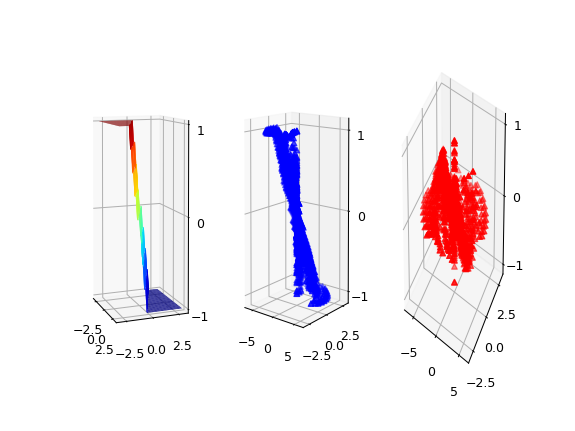

In [26]:
# Gen a bunch of random initial conditions
n=100
xs = np.random.uniform(-3, 3, n)
x_dots = np.random.uniform(-3, 3, n)
ics = zip(xs, x_dots)

def eval_policy(x):
    mesh = policy.get_mesh()
    ovs  = policy.get_output_values()
    return mesh.Eval(ovs, x)

# Do dircol from them
# Compare policy at each knot point of the dircol solution!!!
knot_ics, knot_expected_us, knot_found_us, knot_SSE = [], [], [], 0
traj_ics, traj_expected_us, traj_found_us, traj_SSE = [], [], [], 0
for ic in ics:
    dircol, result = do_dircol(ic=ic, warm_start="linear", seed=1776, should_vis=False)
    # Could compare just the knot points...
    times   = dircol.GetSampleTimes().T
    x_knots = dircol.GetStateSamples().T
    u_knots = dircol.GetInputSamples().T
#     print(times.shape, x_knots.shape, u_knots.shape)
    assert len(times) == len(x_knots) and len(x_knots) == len(u_knots)
    for t, x, u in zip(times, x_knots, u_knots):
        expected_u = eval_policy(x)
        found_u    = u
#         print(expected_u, found_u)
        knot_ics.append(x)
        knot_expected_us.append(expected_u)
        knot_found_us.append(found_u)
        knot_SSE += (found_u - expected_u)**2
    
    # ...and the interpolation points too!
    x_trajectory = dircol.ReconstructStateTrajectory()
    u_trajectory = dircol.ReconstructInputTrajectory()
    for t in np.linspace(times[0], times[-1], 100): # Pick uniform 100 times along the trajectory!
        x = x_trajectory.value(t)
        u = u_trajectory.value(t)
        expected_u = eval_policy(x)
        found_u    = u[0] # To go from shape (1, 1) -> (1,)
        traj_ics.append(x)
        traj_expected_us.append(expected_u)
        traj_found_us.append(found_u)
        traj_SSE += (found_u - expected_u)**2

knot_MSE = knot_SSE / n
traj_MSE = traj_SSE / n

print("knot_MSE: {}, traj_MSE: {}".format(knot_MSE, traj_MSE))

ics, expected_us, found_us = knot_ics, knot_expected_us, knot_found_us
# ics, expected_us, found_us = traj_ics, traj_expected_us, traj_found_us
print(list((np.array(l).shape for l in (ics, expected_us, found_us))))

# Plot expected vs actual, in a 3d graph, since we have a 2d state space...
# Here's the reference graph, in all of it's glory...
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
ax = fig.add_subplot(131, projection='3d')
Pi = np.reshape(policy.get_output_values(), Q.shape)
surf = ax.plot_surface(Q, Qdot, Pi, rstride=1, cstride=1,
                        cmap=cm.jet)

# Plot expected vs actual, in a 3d graph, since we have a 2d state space...
# 3d scatter for the actuals?
# from mpl_toolkits.mplot3d import Axes3D
# fig = plt.figure()
ax = fig.add_subplot(132, projection='3d')
xs, ys = zip(*ics)
zs = found_us
ax.scatter(xs, ys, zs, c='b', marker='^')

# Plot the residuals here!
ax = fig.add_subplot(133, projection='3d')
xs, ys = zip(*ics)
zs = np.array(expected_us) - np.array(found_us)
ax.scatter(xs, ys, zs, c='r', marker='^')

## Let's see what nets we can fit to this policy!

[1,     1] loss: 2.505
[1,     2] loss: 2.330
[1,     3] loss: 1.752
[1,     4] loss: 1.497
[1,     5] loss: 1.213
[1,     6] loss: 1.021
[1,     7] loss: 0.889
[1,     8] loss: 0.799
[1,     9] loss: 0.733
[1,    10] loss: 0.660
[2,     1] loss: 0.570
[2,     2] loss: 0.532
[2,     3] loss: 0.451
[2,     4] loss: 0.358
[2,     5] loss: 0.332
[2,     6] loss: 0.296
[2,     7] loss: 0.244
[2,     8] loss: 0.205
[2,     9] loss: 0.181
[2,    10] loss: 0.170
[3,     1] loss: 0.163
[3,     2] loss: 0.151
[3,     3] loss: 0.133
[3,     4] loss: 0.117
[3,     5] loss: 0.106
[3,     6] loss: 0.095
[3,     7] loss: 0.085
[3,     8] loss: 0.081
[3,     9] loss: 0.076
[3,    10] loss: 0.067
[4,     1] loss: 0.064
[4,     2] loss: 0.062
[4,     3] loss: 0.059
[4,     4] loss: 0.056
[4,     5] loss: 0.052
[4,     6] loss: 0.050
[4,     7] loss: 0.048
[4,     8] loss: 0.044
[4,     9] loss: 0.043
[4,    10] loss: 0.042
[5,     1] loss: 0.039
[5,     2] loss: 0.038
[5,     3] loss: 0.038
[5,     4] 

<IPython.core.display.Javascript object>


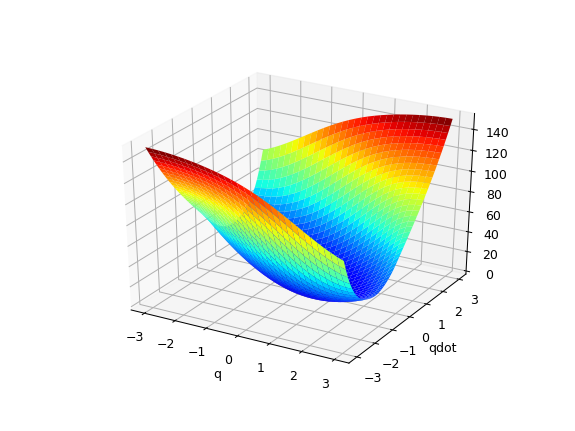

<IPython.core.display.Javascript object>


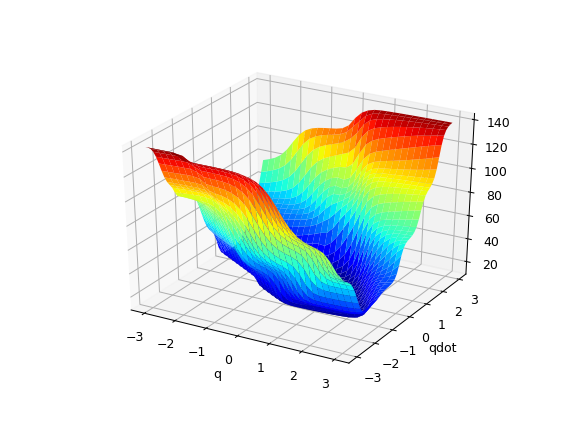

In [156]:
# SUPER OVERFITTING + L2 + parameter distance metric!
import torch
import torch.nn as nn
import torch.optim as optim

from nn_system.NNSystemHelper import FC, FCBIG, MLPSMALL#, MLP

class MLP(nn.Module):
    def __init__(self, n_inputs=4, h_sz=256, layer_norm=False):
        super(MLP, self).__init__()
        self.n_inputs = n_inputs
        self.layer_norm = layer_norm

        self.l1 = nn.Linear(self.n_inputs, h_sz)
        self.ln1 = nn.LayerNorm(h_sz)
        self.tanh1 = torch.tanh
        self.l2 = nn.Linear(h_sz, h_sz)
        self.ln2 = nn.LayerNorm(h_sz)
        self.tanh2 = torch.tanh
        self.l3 = nn.Linear(h_sz, 1)
    
    def forward(self, x):
        x = self.l1(x)
        if self.layer_norm: x = self.ln1(x)
        x = self.tanh1(x)
        x = self.l2(x)
        if self.layer_norm: x = self.ln2(x)
        x = self.tanh2(x)
        x = self.l3(x)
        return x

# net = FCBIG(2)
net = MLPSMALL(2)
# net = MLP(2, 16)

criterion = nn.MSELoss()
# optimizer = optim.SGD(net.parameters(), lr=1e-4, momentum=0.3)
optimizer = optim.Adam(net.parameters(), lr=1e-0)

EPOCHS = 10

# My data
coords = zip(Q.flatten(), Qdot.flatten())
cost_to_go
policy.get_output_values()[0]

def my_gen():
    for _ in range(10):
#     idxs = np.random.uniform(0, 51*31, 1000).astype(np.int)
#     inputs = np.array(coords)[idxs]
#     labels = np.array(cost_to_go)[idxs]
#     labels = policy.get_output_values()[0]

        inputs = np.array(coords)
        labels = cost_to_go.reshape(-1, 1)
#         labels = policy.get_output_values()[0].reshape(-1, 1)
        yield inputs, labels
    
for epoch in range(EPOCHS):
    running_loss = 0.0
    for i, data in enumerate(my_gen(), 0):
        # Unpack data
        inputs, labels = data
        inputs = torch.tensor(inputs)
        labels = torch.tensor(labels)

        # Forward pass
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if (i+1) % 1 == 0:
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

print('Finished Training')


fig = plt.figure()
ax = fig.gca(projection='3d')
ax.set_xlabel("q")
ax.set_ylabel("qdot")

fig2 = plt.figure()
ax2 = fig2.gca(projection='3d')
ax2.set_xlabel("q")
ax2.set_ylabel("qdot")

J = np.reshape(cost_to_go, Q.shape)
surf = ax.plot_surface(Q, Qdot, J, rstride=1, cstride=1,
                       cmap=cm.jet)
J_pred = np.reshape(net.forward(torch.tensor(coords)).data.numpy(), Q.shape)
surf = ax2.plot_surface(Q, Qdot, J_pred, rstride=1, cstride=1,
                       cmap=cm.jet)

# Pi = np.reshape(policy.get_output_values(), Q.shape)
# surf = ax.plot_surface(Q, Qdot, Pi, rstride=1, cstride=1,
#                         cmap=cm.jet)
# Pi_pred = np.reshape(net.forward(torch.tensor(coords)).data.numpy(), Q.shape)
# surf = ax2.plot_surface(Q, Qdot, Pi_pred, rstride=1, cstride=1,
#                        cmap=cm.jet)

## Can a net fit to this policy when it only get's stochastic samples of the known optimal policy

In [ ]:
# Same as above but just change up the sampling method!
# First, let's generate a bunch of rollouts from initial conditions, using the simulator and the logger?
# data_ics = []
# data = []
from __future__ import print_function, absolute_import

import math
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import HTML
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

from pydrake.all import (DiagramBuilder, SignalLogger, Simulator, VectorSystem)
from pydrake.examples.pendulum import PendulumPlant
from pydrake.systems.controllers import (
    DynamicProgrammingOptions, FittedValueIteration, PeriodicBoundaryCondition)
from visualizer import PendulumVisualizer



# Animate the resulting policy.
builder = DiagramBuilder()
di = builder.AddSystem(LinearSystem(A, B, C, D))


# TODO(russt): add wrap-around logic to barycentric mesh
# (so the policy has it, too)
# class WrapTheta(VectorSystem):
#     def __init__(self):
#         VectorSystem.__init__(self, 2, 2)

#     def _DoCalcVectorOutput(self, context, input, state, output):
#         output[:] = input
#             twoPI = 2.*math.pi
#             output[0] = output[0] - twoPI * math.floor(output[0] / twoPI)

# wrap = builder.AddSystem(WrapTheta())
# builder.Connect(di.get_output_port(0), wrap.get_input_port(0))
vi_policy = builder.AddSystem(policy)
# builder.Connect(wrap.get_output_port(0), vi_policy.get_input_port(0))
builder.Connect(vi_policy.get_output_port(0), di.get_input_port(0))
builder.Connect(di.get_output_port(0), vi_policy.get_input_port(0))

logger = builder.AddSystem(SignalLogger(2))
logger._DeclarePeriodicPublish(0.033333, 0.0)
builder.Connect(di.get_output_port(0), logger.get_input_port(0))

diagram = builder.Build()
simulator = Simulator(diagram)
simulator.set_publish_every_time_step(False)

# state = simulator.get_mutable_context().get_mutable_continuous_state_vector()
# state.SetFromVector([-1., -1.])


# for _ in range(1):
# state.SetFromVector([-1., -1.])
# try:
simulator.StepTo(1.)
# except error:
#     print(error)
# print(logger.sample_times(), logger.data())

# simulator.Initialize()
# state = simulator.get_mutable_context().get_mutable_continuous_state_vector()
# state.SetFromVector([1., 1.])

# simulator.StepTo(1.)
# print(logger.sample_times(), logger.data())

In [ ]:
# Then, let's try to fit it with an NN


In [ ]:
# And what if you add noise???? <- maybe this is exactly what's going on?...

## Can traj opt inited with the above fitted optimal policy stay in place / find the optimal off of a small perturbation?